<a href="https://www.kaggle.com/code/vibhavohri/urgency-keyword-detection-with-bert-test?scriptVersionId=254125954" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/urgency-labeled-enron-emails/FinalCleanDatabase.csv


2025-08-04 10:08:04.174492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754302084.409191      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754302084.477048      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Class distribution:
 Urgency
3.0    723
0.0    228
5.0    150
2.0    104
1.0     28
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/4 - Training Loss: 1.8794 - Validation Loss: 1.9077
Epoch 2/4 - Training Loss: 1.8802 - Validation Loss: 1.8821
Epoch 3/4 - Training Loss: 1.8341 - Validation Loss: 1.8584
Epoch 4/4 - Training Loss: 1.8289 - Validation Loss: 1.8347


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


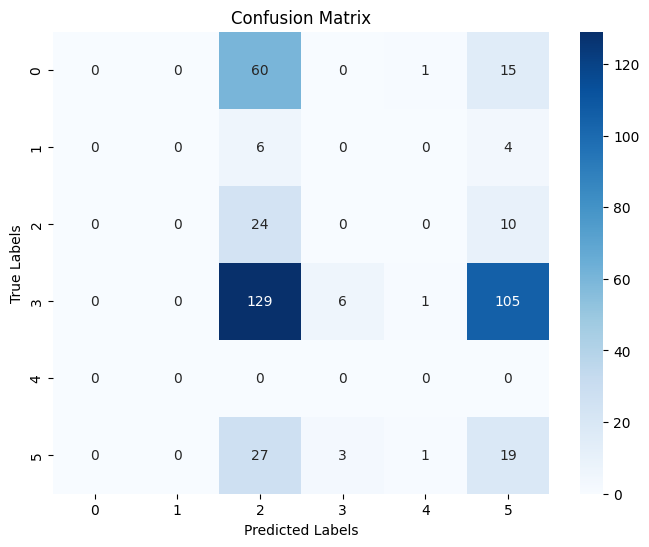

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


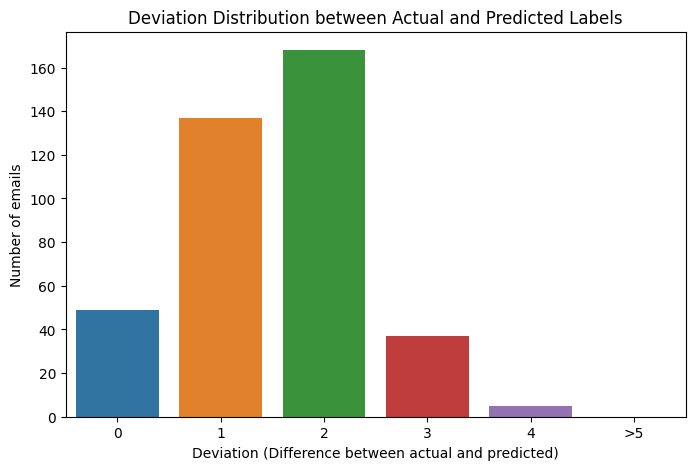

 Fold 0 -- Acc: 0.1192 | F1: 0.0651 | Prec: 0.4141 | Rec: 0.1192
Epoch 1/4 - Training Loss: 1.7676 - Validation Loss: 1.8515
Epoch 2/4 - Training Loss: 1.7651 - Validation Loss: 1.8324
Epoch 3/4 - Training Loss: 1.7655 - Validation Loss: 1.8099
Epoch 4/4 - Training Loss: 1.7403 - Validation Loss: 1.7877


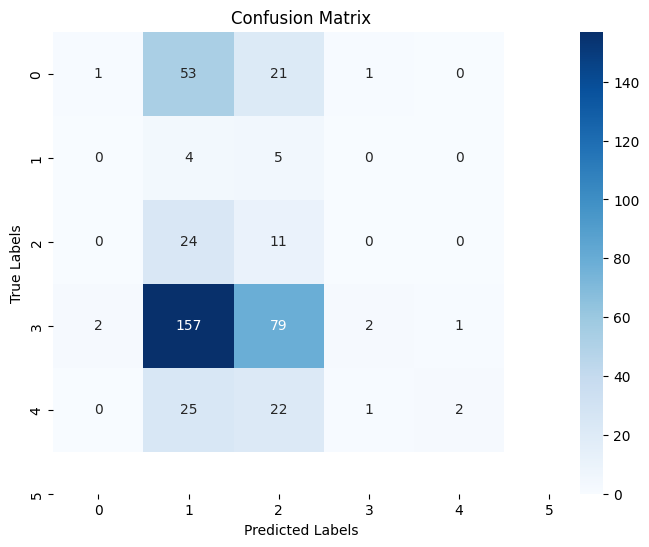

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


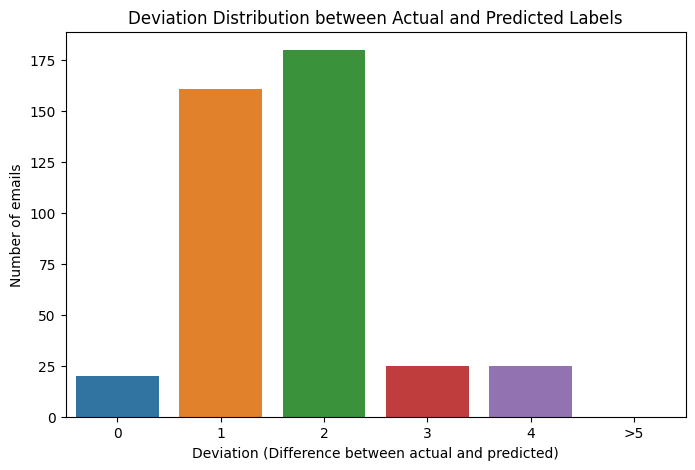

 Fold 1 -- Acc: 0.0487 | F1: 0.0349 | Prec: 0.4430 | Rec: 0.0487
Epoch 1/4 - Training Loss: 1.8284 - Validation Loss: 1.9337
Epoch 2/4 - Training Loss: 1.8009 - Validation Loss: 1.9115
Epoch 3/4 - Training Loss: 1.8065 - Validation Loss: 1.8919
Epoch 4/4 - Training Loss: 1.7680 - Validation Loss: 1.8736


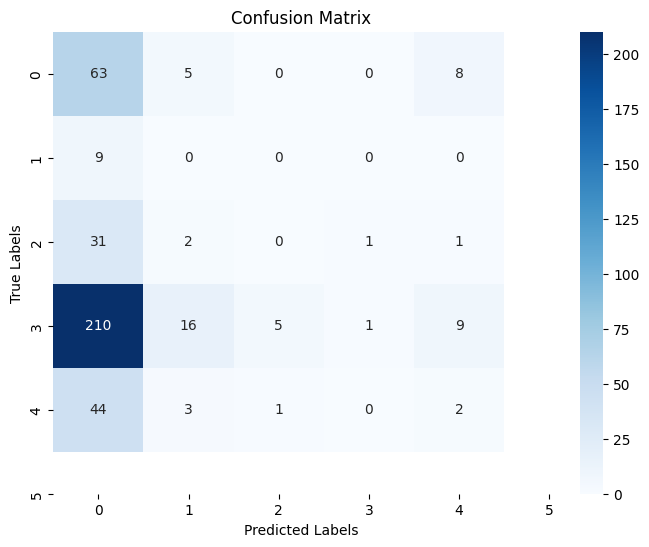

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


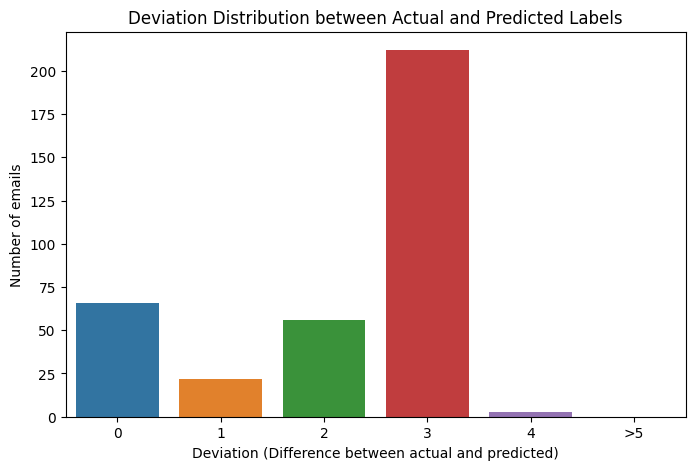

 Fold 2 -- Acc: 0.1606 | F1: 0.0656 | Prec: 0.3380 | Rec: 0.1606


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from transformers import BertTokenizerFast, BertModel
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import torch.nn.functional as F

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

df = pd.read_csv("/kaggle/input/urgency-labeled-enron-emails/FinalCleanDatabase.csv")
df = df.dropna(subset=['Urgency'])
print("Class distribution:\n", df['Urgency'].value_counts())

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', use_fast=True)

texts = (df['Subject'].fillna('') + ' ' + df['Body'].fillna('')).tolist()

class PhishingEmailClassifier(nn.Module):
    def __init__(self, num_classes=6, unfreeze_bert=False):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        if not unfreeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = output.last_hidden_state[:, 0, :]
        return self.classifier(self.dropout(cls_token))

MAX_SEQ_LENGTH = 128
EPOCHS = 4
BATCH_SIZE = 64
LEARNING_RATE = 2e-5
UNFREEZE_BERT = False
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PATIENCE = 2

encodings = tokenizer(
    texts,
    padding='max_length',
    truncation=True,
    max_length=MAX_SEQ_LENGTH,
    return_tensors='pt'
)
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']
labels = torch.tensor(df['Urgency'].values, dtype=torch.long)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def train_model(model, train_loader, val_loader, lr=LEARNING_RATE, epochs=EPOCHS, patience=PATIENCE, fold=0, device=DEVICE):
    model = model.to(device)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_loss = float('inf')
    patience_counter = 0
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    best_model_path = f"best_model_fold_{fold}_{timestamp}.pt"

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            input_ids_b, attention_mask_b, labels_b = [b.to(device) for b in batch]
            optimizer.zero_grad()
            logits = model(input_ids_b, attention_mask_b)
            loss = criterion(logits, labels_b)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids_b, attention_mask_b, labels_b = [b.to(device) for b in batch]
                logits = model(input_ids_b, attention_mask_b)
                loss = criterion(logits, labels_b)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load(best_model_path))
    return model

def evaluate_model(model, val_loader, device=DEVICE):
    model.eval()
    all_logits, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids_b, attention_mask_b, labels_b = [b.to(device) for b in batch]
            logits = model(input_ids_b, attention_mask_b)
            all_logits.append(logits)
            all_labels.append(labels_b)

    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    preds = np.argmax(probs, axis=1)
    true_labels = all_labels.cpu().numpy()

    return (
        accuracy_score(true_labels, preds),
        f1_score(true_labels, preds, average='weighted'),
        precision_score(true_labels, preds, average='weighted'),
        recall_score(true_labels, preds, average='weighted'),
        confusion_matrix(true_labels, preds),
        probs,
        true_labels,
        preds
    )

def plot_deviation_graph(true_labels, pred_labels, max_deviation=5):
    deviations = np.abs(true_labels - pred_labels)
    counts = [np.sum(deviations == i) for i in range(max_deviation)]
    counts.append(np.sum(deviations > max_deviation))
    labels = [str(i) for i in range(max_deviation)] + [f">{max_deviation}"]
    plt.figure(figsize=(8, 5))
    sns.barplot(x=labels, y=counts)
    plt.xlabel('Deviation (Difference between actual and predicted)')
    plt.ylabel('Number of emails')
    plt.title('Deviation Distribution between Actual and Predicted Labels')
    plt.show()

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(df)), df['Urgency'])):
    train_labels = labels[train_idx]
    class_counts = np.bincount(train_labels.numpy())
    epsilon = 1e-8
    class_weights = 1. / (class_counts + epsilon)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

    train_dataset = TensorDataset(
        input_ids[train_idx],
        attention_mask[train_idx],
        train_labels
    )
    val_dataset = TensorDataset(
        input_ids[val_idx],
        attention_mask[val_idx],
        labels[val_idx]
    )

    sample_weights = np.zeros(len(train_labels))
    for i, label in enumerate(train_labels.numpy()):
        sample_weights[i] = class_weights[label].item()

    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = PhishingEmailClassifier(num_classes=6, unfreeze_bert=UNFREEZE_BERT)
    trained_model = train_model(
        model,
        train_loader,
        val_loader,
        lr=LEARNING_RATE,
        epochs=EPOCHS,
        patience=PATIENCE,
        fold=fold,
        device=DEVICE
    )

    acc, f1, prec, rec, cm, probabilities, true_labels, pred_labels = evaluate_model(trained_model, val_loader, device=DEVICE)

    class_names = [str(i) for i in range(6)]
    plot_confusion_matrix(cm, class_names)
    plot_deviation_graph(true_labels, pred_labels)

    print(f" Fold {fold} -- Acc: {acc:.4f} | F1: {f1:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}")